In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rasterio.plot import show
from scipy.special import expit, logit

from distmetrics import (
    compute_mahalonobis_dist_2d,
    compute_transformer_zscore,
    despeckle_rtc_arrs_with_tv,
    get_asf_rtc_burst_ts,
    load_transformer_model,
    read_asf_rtc_image_data,
)

References:

- CNN story: https://www.cnn.com/2024/05/25/world/video/damage-papua-new-guinea-landslide-ldn-digvid
- ASF Search: https://search.asf.alaska.edu/#/?polygon=POINT(143.3641%20-5.3821)&zoom=13.000&center=143.364,-5.425&resultsLoaded=true&granule=OPERA_L2_RTC-S1_T009-019294-IW2_20240603T084748Z_20240603T133726Z_S1A_30_v1.0&maxResults=250&dataset=OPERA-S1&productTypes=RTC

In [4]:
BURST_ID = "T009_019294_IW2"

In [5]:
df_rtc_ts = get_asf_rtc_burst_ts(BURST_ID)
print("# of results: ", df_rtc_ts.shape[0])
df_rtc_ts.head()

# of results:  60


,opera_id,acq_datetime,polarization,track_number,geometry,url_vh,url_vv,dedup_id
0,OPERA_L2_RTC-S1_T009-019294-IW2_20220109T08473...,2022-01-09 08:47:38+00:00,VV+VH,9,"POLYGON ((143.32562 -5.40824, 144.11311 -5.233...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T009-019294-IW2_20220109T084738Z
1,OPERA_L2_RTC-S1_T009-019294-IW2_20220121T08473...,2022-01-21 08:47:37+00:00,VV+VH,9,"POLYGON ((143.32598 -5.40772, 144.11344 -5.232...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T009-019294-IW2_20220121T084737Z
2,OPERA_L2_RTC-S1_T009-019294-IW2_20220202T08473...,2022-02-02 08:47:36+00:00,VV+VH,9,"POLYGON ((143.3266 -5.40807, 144.11408 -5.2331...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T009-019294-IW2_20220202T084736Z
3,OPERA_L2_RTC-S1_T009-019294-IW2_20220214T08473...,2022-02-14 08:47:37+00:00,VV+VH,9,"POLYGON ((143.32545 -5.40826, 144.11296 -5.233...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T009-019294-IW2_20220214T084737Z
4,OPERA_L2_RTC-S1_T009-019294-IW2_20220226T08473...,2022-02-26 08:47:36+00:00,VV+VH,9,"POLYGON ((143.32548 -5.40829, 144.11299 -5.233...",https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,OPERA_L2_RTC-S1_T009-019294-IW2_20220226T084736Z


**Warning**: sometime this cell fails and must be re-run due to a transient server error.

In [6]:
arrs_vv, profiles = read_asf_rtc_image_data(df_rtc_ts.url_vv.tolist())
arrs_vh, _ = read_asf_rtc_image_data(df_rtc_ts.url_vh.tolist())

Loading RTC data: 100%|█| 60/60 [00:51<00:00,  1.16i
Loading RTC data: 100%|█| 60/60 [00:53<00:00,  1.13i


In [9]:
arrs_vv_d = despeckle_rtc_arrs_with_tv(arrs_vv)
arrs_vh_d = despeckle_rtc_arrs_with_tv(arrs_vh)

Despeckling bursts: 100%|█| 60/60 [00:18<00:00,  6.1
Despeckling bursts: 100%|█| 60/60 [00:16<00:00,  6.6


In [11]:
for k, date in enumerate(df_rtc_ts.acq_datetime):
    print(k, date)

0 2022-01-09 08:47:38+00:00
1 2022-01-21 08:47:37+00:00
2 2022-02-02 08:47:36+00:00
3 2022-02-14 08:47:37+00:00
4 2022-02-26 08:47:36+00:00
5 2022-03-10 08:47:36+00:00
6 2022-03-22 08:47:37+00:00
7 2022-04-03 08:47:37+00:00
8 2022-04-15 08:47:37+00:00
9 2022-04-27 08:47:38+00:00
10 2022-05-09 08:47:38+00:00
11 2022-05-21 08:47:39+00:00
12 2022-06-02 08:47:40+00:00
13 2022-06-14 08:47:41+00:00
14 2022-06-26 08:47:42+00:00
15 2022-07-08 08:47:42+00:00
16 2022-07-20 08:47:43+00:00
17 2023-01-04 08:47:44+00:00
18 2023-01-16 08:47:43+00:00
19 2023-01-28 08:47:43+00:00
20 2023-02-09 08:47:42+00:00
21 2023-10-07 08:47:51+00:00
22 2023-10-19 08:47:51+00:00
23 2023-10-31 08:47:51+00:00
24 2023-11-12 08:47:51+00:00
25 2023-11-24 08:47:50+00:00
26 2023-12-06 08:47:50+00:00
27 2023-12-18 08:47:49+00:00
28 2023-12-30 08:47:49+00:00
29 2024-01-11 08:47:48+00:00
30 2024-01-23 08:47:48+00:00
31 2024-02-04 08:47:47+00:00
32 2024-02-16 08:47:47+00:00
33 2024-02-28 08:47:47+00:00
34 2024-03-11 08:47:47+0

In [22]:
EVENT_TS = pd.Timestamp("2024-05-28", tz="utc")
N_PRE_IMAGES = 10

pre_indices = [
    k for (k, date) in enumerate(df_rtc_ts.acq_datetime.tolist()) if date < EVENT_TS
][-N_PRE_IMAGES:]
post_index = [
    k for (k, date) in enumerate(df_rtc_ts.acq_datetime.tolist()) if date >= EVENT_TS
][0]
pre_indices, post_index

([30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 40)

In [23]:
transformer = load_transformer_model(model_token="latest")

In [24]:
pre_imgs_vv = [arrs_vv_d[k] for k in pre_indices]
pre_imgs_vh = [arrs_vh_d[k] for k in pre_indices]

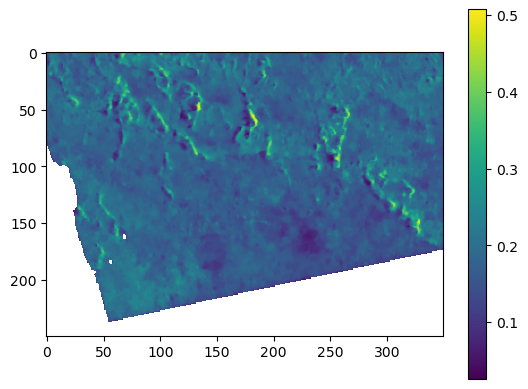

In [25]:
sy = np.s_[1250:1500]
sx = np.s_[400:750]
plt.imshow(pre_imgs_vv[0][sy, sx])
plt.colorbar()

In [26]:
pre_vv_c = [arr[sy, sx] for arr in pre_imgs_vv]
pre_vh_c = [arr[sy, sx] for arr in pre_imgs_vh]

post_vv_c = arrs_vv_d[post_index][sy, sx]
post_vh_c = arrs_vh_d[post_index][sy, sx]

In [27]:
dist_ob = compute_transformer_zscore(
    transformer,
    pre_vv_c,
    pre_vh_c,
    post_vv_c,
    post_vh_c,
    stride=2,
    agg="max",
    batch_size=256,
    memory_strategy="high",
)

Chips Traversed: 100%|█| 78/78 [00:09<00:00,  7.88it


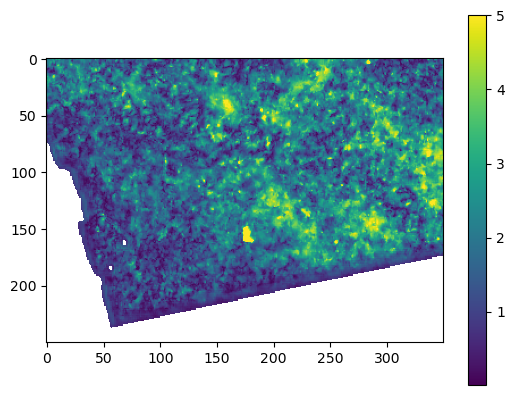

In [28]:
plt.imshow(dist_ob.dist, vmax=5)
plt.colorbar()

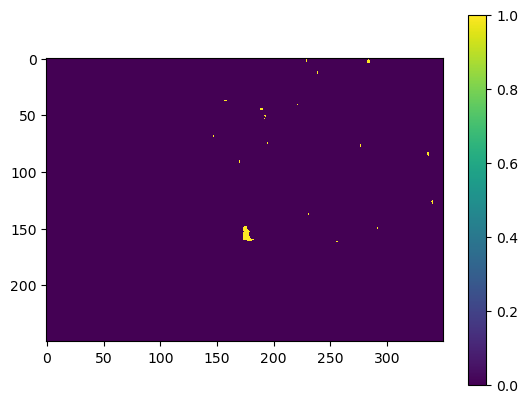

In [32]:
plt.imshow(dist_ob.dist > 5.5, vmax=1, interpolation="none")
plt.colorbar()

**Warninig**: the stat outputs of the function above are in `logits` NOT `gamma naught`. Hence `expit`!

<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_47687/3498562707.py:3: SyntaxWarning: invalid escape sequence '\g'
  plt.title("Mean Estimate VV ($\gamma$)")


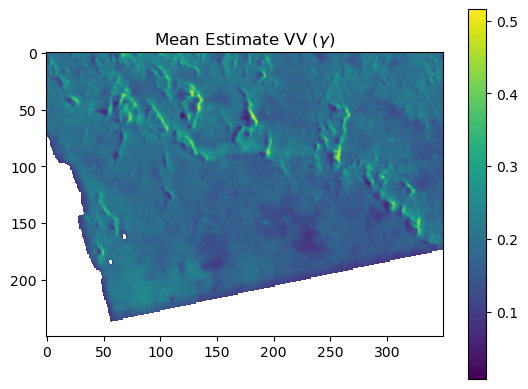

In [30]:
from scipy.special import expit

plt.title("Mean Estimate VV ($\gamma$)")
plt.imshow(expit(dist_ob.mean[0, ...]))
plt.colorbar()

Can't really apply `expit` to `sigma`...

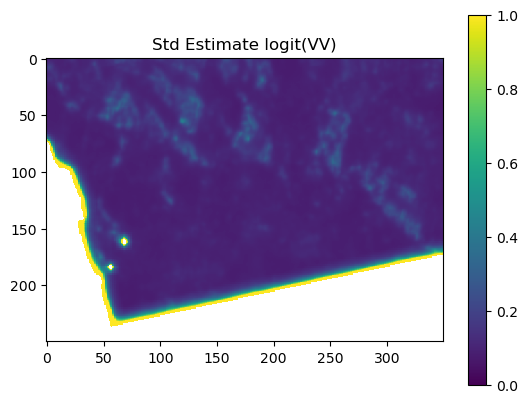

In [31]:
plt.title("Std Estimate logit(VV)")
plt.imshow(dist_ob.std[0, ...], vmax=1, vmin=0)
plt.colorbar()